# 4. 머신러닝 기반 변동성

- 변동성: 위험의 지표 -> 자산 가격 산정, 위험 관리 등에서 중요한 변수
- 실현 변동성: 변동성 예측 방법의 성능 계산에 사용

In [2]:
!pip install arch

   ---------------------------------------- 0.0/929.7 kB ? eta -:--:--
   ---------------------------------------- 929.7/929.7 kB 15.4 MB/s  0:00:00


In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [2]:
stocks='^GSPC'
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2021,8,1)
s_p500=yf.download(stocks,start=start,end=end,interval='1d') #DataFrame

[*********************100%***********************]  1 of 1 completed


In [3]:
ret=100*(s_p500.pct_change()[1:]['Close']) # 첫 행: missing value
# 실현 수익
realized_vol=ret.rolling(5).std()

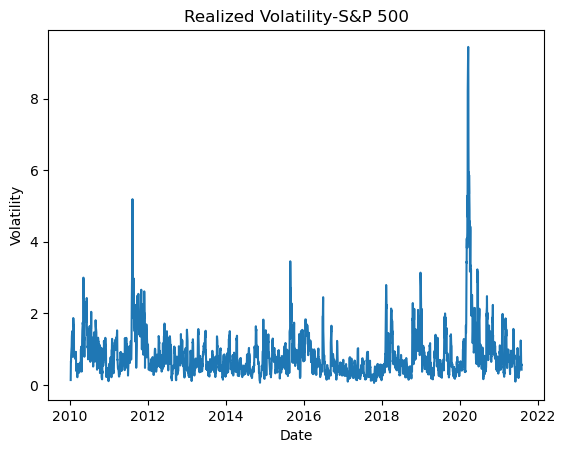

In [4]:
plt.Figure(figsize=(10,6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility-S&P 500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

# 고전정 변동성 모델

1. ARCH 모델:
$\\ \sigma^2_t=w+\sum^p_{k=1}\alpha_k(r_{t-k})^2$
- 평균 모델:
$\\ r_t=\sigma_t \epsilon_t$
- 양의 분산 조건:
- $w>0$
- $\alpha_k \ge 0$
- 시간에 따라 변하는 조건부 분산의 속성을 가짐 -> 변동성 클러스터링 현상 모델링 가능
- 변동성 클러스터링: 작은 변화는 대개 작은 변화 뒤에 옴

In [9]:
# ARCH 모델
n=252
split_date=ret.iloc[-n:].index

sgm2=ret.var() # S&P 500의 분산 (ret: 수익률 DataFrame)
K=ret.kurtosis() # S&P 500의 첨도
alpha=(-3.0*sgm2+np.sqrt(9.0*sgm2**2-12.0*(3.0*sgm2-K)*K))/(6*K) # 첨도 사용한 수학적 역산(알파가 이정도 되어야 함)
omega=(1-alpha)*sgm2
initial_parmeters=[float(alpha), float(omega)] # 모델이 더 빠르게 최적값 찾기 위한 초기 parameter

In [6]:
# 코드를 기계어(C/C++)로 컴파일하여 실행 속도를 높임
@jit(nopython=True, parallel=True) # 병렬 처리로 시간 단축
# 최적화시킬 목적함수
def arch_likelihood(initial_parmeters, retv): # retv: 수익률 numpy
    omega=abs(initial_parmeters[0])
    alpha=abs(initial_parmeters[1])
    T=len(retv)
    logliks=0
    sigma2=np.zeros(T)
    sigma2[0]=np.var(retv)
    for t in range(1,T):
        sigma2[t]=omega+alpha*(retv[t-1])**2 # ARCH(1) 식
    # 음의 로그우드로 만듦 -> 목적식 최소화
    logliks=np.sum(0.5*(np.log(sigma2)+retv**2/sigma2)) # 평균 모델이 참일 때, 현재 데이터가 나올 확률
    return logliks

In [7]:
def opt_params(x0, retv):
    #x0: initial value(최적화 대상), args: 함수의 두번째 이후 인자들에(invariable) 
    opt_result=opt.minimize(arch_likelihood, x0=x0, args=(retv), method='Nelder-Mead',options={'maxiter':5000})
    params=opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-']*28),opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [11]:
retv=ret.values.flatten() # S&P 500 수익률 값
params=opt_params(initial_parmeters,retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1384.4549035108541
             x: [ 7.015e-01  3.913e-01]
           nit: 30
          nfev: 58
 final_simplex: (array([[ 7.015e-01,  3.913e-01],
                       [ 7.016e-01,  3.913e-01],
                       [ 7.016e-01,  3.914e-01]]), array([ 1.384e+03,  1.384e+03,  1.384e+03]))

Resulting params = [0.70152949 0.39126701]


In [15]:
def arch_apply(ret):
    omega=params[0]
    alpha=params[1]
    T=len(ret)
    sigma2_arch=np.zeros(T+1)
    sigma2_arch[0]=np.var(ret)
    for t in range(1,T):
        sigma2_arch[t]=omega+alpha*ret.iloc[t-1]**2
    return sigma2_arch

In [16]:
sigma2_arch=arch_apply(ret)

In [ ]:
# mean: 평균 방정식의 평균, vol: default=GARCH
arch=arch_model(ret,mean='zero',vol='ARCH',p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -4061.27
Distribution:                  Normal   AIC:                           8126.54
Method:            Maximum Likelihood   BIC:                           8138.50
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        12:01:14   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7014  5.002e-02     14.023  1.129e-44 [  0.603,  0.79

In [ ]:
bic_arch=[]
for p in range(1,5):
    arch=arch_model(ret, mean='zero',vol='ARCH',p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param=p
arch=arch_model(ret,mean='zero',vol='ARCH',p=best_param).fit(disp='off')
print(arch.summary())
forecast=arch.forecast(start=split_date[0]) # start이후로 데이터가 끝나는 날까지 예측
forecast_arch=forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3709.51
Distribution:                  Normal   AIC:                           7429.03
Method:            Maximum Likelihood   BIC:                           7458.91
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        12:06:11   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2794  2.580e-02     10.829  2.498e-27   [  0.22

In [21]:
# Mean Squared Error
rmse_arch=np.sqrt(mse(realized_vol[-n:]/100,
                      np.sqrt(forecast_arch.variance.iloc[-len(split_date):])/100))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0023


2. GARCH 모델
GARCH(p,q): $\sigma^2_t=\omega+\sum^q_{k=1}\alpha_kr^2_{t-k}+\sum^p_{k=1}\beta_k\sigma^2_{t-k}$
- $\omega, \ \beta,\  \alpha$: 추정하려는 매개변수
- $p,\  q$: 모델의 최대 지연
- 일관성 조건: $\omega > 0,\ \beta \ge 0,\ \alpha \ge 0 ,\ \alpha + \beta< 1$
- 무한차 ARCH로 표현 가능: $\sigma^2_t=\omega(1+\beta+\beta^2+...)+\alpha\sum^\infin_{k=1}\beta^{k-1}r_{t-k}$

In [30]:
# GARCH 모델
a0=0.0001
sgm2=ret.var()
K=ret.kurtosis()
h=1-alpha/sgm2
alpha=float(np.sqrt(K*(1-h**2)/(2.0*(K+3))))
beta=float(np.abs(h-omega))
omega=float((1-omega)*sgm2)
initial_parmeters=np.array([omega,alpha,beta])
print('initial_parmeters: {}'.format(initial_parmeters))

initial_parmeters: [0.39026315 0.53802045 0.11859295]


In [32]:
retv=ret.values.flatten()
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parmeters, retv):
    omega=initial_parmeters[0]
    alpha=initial_parmeters[1]
    beta=initial_parmeters[2]
    T=len(retv)
    logliks=0
    sigma2=np.zeros(T)
    sigma2[0]=np.var(retv)
    for t in range(1,T):
        sigma2[t]=omega+alpha*(retv[t-1])**2+beta*sigma2[t-1]
    logliks=np.sum(0.5*(np.log(sigma2)+retv**2/sigma2))
    return logliks

In [25]:
def garch_constraint(initial_parmeters):
    alpha=initial_parmeters[0]
    gamma=initial_parmeters[1]
    beta=initial_parmeters[2]
    return np.array([1-alpha-beta])
bounds=[(0.0,1.0),(0.0,1.0),(0.0,1.0)]

In [ ]:
def opt_paramsG(initial_parmeters, retv):
    # bounds: 각 변수의 범위, constraints: 해당 식이 양수이도록
    opt_result=opt.minimize(garch_likelihood,x0=initial_parmeters,constraints=np.array([1-alpha-beta]),bounds=bounds,args=(retv),method='Nelder-Mead',options={'maxiter':5000})
    params=opt_result.x
    return params

In [33]:
params=opt_paramsG(initial_parmeters,retv)

In [34]:
def garch_apply(ret):
    omega=params[0]
    alpha=params[1]
    beta-params[2]
    T=len(ret)
    sigma2=np.zeros(T+1)
    sigma2[0]=np.var(ret)
    for t in range(1,T):
        sigma2[t]=omega+alpha*ret[t-1]**2+beta*sigma2[t-1]
    return sigma2

In [35]:
garch=arch_model(ret,mean='zero',vol='GARCH',p=1,o=0,q=1).fit(disp='off')
print(garch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        13:09:43   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [36]:
bic_garch=[]
for p in range(1,5):
    for q in range(1,5):
        garch=arch_model(ret, mean='zero',vol='GARCH',p=p,o=0,q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic==np.min(bic_garch):
            best_param=p, q
garch=arch_model(ret,mean='zero',vol='GARCH',p=best_param[0],o=0,q=best_param[1]).fit(disp='off')
print(garch.summary())
forecast=garch.forecast(start=split_date[0])
forecast_garch=forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3654.98
Distribution:                  Normal   AIC:                           7315.97
Method:            Maximum Likelihood   BIC:                           7333.90
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        13:14:46   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0393  8.429e-03      4.664  3.100e-06 [2.

In [37]:
rmse_garch=np.sqrt(mse(realized_vol[-n:]/100, np.sqrt(forecast_garch.variance.iloc[-len(split_date):])/100))
print(rmse_garch)

0.002538998834702003


GARCH: 변동성 클러스터링 + 수익의 급첨(정규분포보다 더 뾰족 + 양쪽 꼬리가 더 두꺼움) ~ 설명 위해 수익의 독립성 가정 x

3. GJR-GARCH
: 나쁜 소식이 좋은 소식보다 더 큰 영향을 미치는 방식 ~ 비대칭 효과를 잘 모델링함
- 비대칭이 있는 경우 손실의 분포가 이익의 분포보다 꼬리가 두꺼워짐
- 매개변수 $\gamma$를 하나 더 포함 ~ 발표의 비대칭성 제어

In [43]:
bic_gjr_garch=[]

for p in range(1,5):
    for q in range(1,5):
        # o=1: gamma 변수 추가 ~ 비대칭성 추가
        gjrgarch=arch_model(ret,mean='zero',p=p,o=1,q=q).fit(disp='off')
        bic_gjr_garch.append(gjrgarch.bic)
        if gjrgarch.bic == np.min(bic_gjr_garch):
            best_param=p, q
gjrgarch=arch_model(ret,mean='zero',p=best_param[0],q=best_param[1],o=1).fit(disp='off')
print(gjrgarch.summary())
forecast=gjrgarch.forecast(start=split_date[0])
forecast_gjrgarch=forecast

                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -3591.15
Distribution:                  Normal   AIC:                           7190.30
Method:            Maximum Likelihood   BIC:                           7214.21
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        13:34:04   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0430  7.754e-03      5.547  2.908e-08 

In [44]:
rmse_gjr_garch=np.sqrt(mse(realized_vol[-n:]/100,
                           np.sqrt(forecast_gjrgarch.variance.iloc[-len(split_date):])/100))
print(rmse_gjr_garch)

0.002378764062401832


4. EGARCH
- 모델: $log(\sigma^2_t)=\omega+\sum^p_{k=1}\beta_klog\sigma^2_{t-k}+\sum^q_{k=1}\alpha_i\frac{|r_{k-1}|}{\sqrt{\sigma^2_{t-k}}}+\sum^q_{k=1}\gamma_k\frac{r_{t-k}}{\sqrt{\sigma^2_{t-k}}}$
- 로그 형식 -> 음의 변동성 피하기 위한 추자 제약 필요 없음 & 레버리지 효과 나타냄

In [45]:
bic_egarch=[]
for p in range(1,5):
    for q in range(1,5):
        egarch=arch_model(ret, mean='zero',vol='EGARCH',p=p,q=q).fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic==np.min(bic_egarch):
            best_param=p, q
egarch=arch_model(ret, mean='zero', vol='EGARCH',p=best_param[0],q=best_param[1]).fit(disp='off')
print(egarch.summary())
forecast=egarch.forecast(start=split_date[0])
forecast_egarch=forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3673.53
Distribution:                  Normal   AIC:                           7353.05
Method:            Maximum Likelihood   BIC:                           7370.98
                                        No. Observations:                 2913
Date:                    일, 1 11 2026   Df Residuals:                     2913
Time:                        13:51:52   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.4573e-03  6.769e-03      0.363      0.717 

In [46]:
rmse_egarch=np.sqrt(mse(realized_vol[-n:]/100,
                        np.sqrt(forecast_egarch.variance.iloc[-len(split_date):])/100))
print(rmse_egarch)

0.0027569406588073817


6. 서포트 백터 회귀: GARCH
- 서포트 백터 머신(SVM): 분류와 회귀 모두에 적용 가능한 지도 학습 알고리즘
- SVM의 목적: 두 부류를 구분하는 최적의 선 찾기
- 초평면(최적의 선 in 선형대수학)에 가장 가깝지만 다른 부류에 속하는 점 사이의 거리를 최대화 함; 서포트 벡터 사이의 마진을 최대화
- 두 점 사이의 거리(서포트 벡터)를 마진 이라고 함
- 분류를 위한 SVM: 서포트 백터 분류(SVC)
- SVM의 모든 특성 유지하며 회귀에 적용: 오차 최소화 & 마진 최대화하는 초평면 찾기; SVR
- SVR을 GARCH 모델에 적용: SVRGARCH
- if 작업하는 데이터가 선형으로 분리될 수 없다면, "커널 함수" -> 비선형과 고차원 데이터를 모델링함

(*) 커널 트릭
: 2차원 평면에서는 선 하나로 나눌 수 없는 데이터를 3차원 공간으로 띄워서 평면으로 자를 수 있게 해주는 변환 함수
- Linear(선형 커널): 데이터 단순 or 변수 많아서 이미 고차원일 때 
- Poly(다항 커널): 데이터를 곡선 형태로 봄
- Radial Basis Function(방사 기저): 가장 강력하고 유연함 ~ 데이터 포인트 하나하나를 중심으로 가우스 분포 일으켜 주변 설명

In [47]:
# SVR-GARCH
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [61]:
realized_vol=ret.rolling(5).std()
realized_vol=pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)
returns_svm=ret**2
returns_svm.reset_index(inplace=True)
del returns_svm['Date']

In [62]:
X=pd.concat([realized_vol,returns_svm],axis=1, ignore_index=True)
X=X[4:].copy()
X=X.reset_index()
X.drop('index',axis=1,inplace=True)

In [63]:
realized_vol=realized_vol.dropna().reset_index()
realized_vol.drop('index',axis=1,inplace=True)

In [57]:
svr_poly=SVR(kernel='poly',degree=2)
svr_lin=SVR(kernel='linear')
svr_rbf=SVR(kernel='rbf')

In [64]:
para_grid = {'gamma':sp_rand(),
             'C':sp_rand(),
             'epsilon':sp_rand()}
clf=RandomizedSearchCV(svr_lin,para_grid)
clf.fit(X.iloc[:-n].values,
        realized_vol.iloc[1:-(n-1)].values.reshape(-1,)) # 1차원 가로 형태로 펴줌
predict_svr_lin=clf.predict(X.iloc[-n:])

In [65]:
predict_svr_lin=pd.DataFrame(predict_svr_lin)
predict_svr_lin.index=ret.iloc[-n:].index

In [66]:
rmse_svr=np.sqrt(mse(realized_vol.iloc[-n:]/100,
                     predict_svr_lin/100))
print(rmse_svr)

0.000459908883765899


# 신경망

- 비용함수 최소화 위해 : 역전파 개념

In [ ]:
from sklearn.neural_network import MLPRegressor
NN_vol=MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN={'hidden_layer_sizes':[(100,50),(50,50),(10,100)], # 은닉층 뉴런 개수
              'max_iter':[500,1000],
              'alpha':[0.00005,0.0005]} # L2 규제
clf=RandomizedSearchCV(NN_vol, para_grid_NN) # 실험 대상, 파라미터 후보
clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
NN_predictions=clf.predict(X.iloc[-n:])

NN_predictions=pd.DataFrame(NN_predictions)
NN_predictions.index=ret.iloc[-n:].index

In [68]:
rmse_NN=np.sqrt(mse(realized_vol.iloc[-n:]/100,
                     NN_predictions/100))
print(rmse_NN)

0.0006470997479833696


In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [71]:
model=keras.Sequential(
    [layers.Dense(256, activation='relu'),
     layers.Dense(128, activation='relu'),
     layers.Dense(1, activation='linear')]
)
model.compile(loss='mse',optimizer='rmsprop')

epochs_trial=np.arange(100,400,4)
batch_trial=np.arange(100,400,4)

DL_pred=[]
DL_RMSE=[]
for i,j,k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol.iloc[1:-(n-1)].values.reshape(-1,), batch_size=k, epochs=j, verbose=False)
    DL_predict=model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:]/100, DL_predict.flatten()/100)))
    DL_pred.append(DL_predict)

DL_predict=pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index=ret.iloc[-n:].index

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [72]:
print(DL_predict)

                   0
Date                
2020-07-31  0.823229
2020-08-03  0.819551
2020-08-04  0.621564
2020-08-05  0.522048
2020-08-06  0.277796
...              ...
2021-07-26  0.571542
2021-07-27  0.612541
2021-07-28  0.547086
2021-07-29  0.578169
2021-07-30  0.473843

[252 rows x 1 columns]


# 베이즈 접근 방법

- 고전적(빈도주의적): 상대 빈도가 참 확률로 수렴
- 베이지안 접근 방식: 확률 분포는 불확실한 것 -> 새로은 정보 들어오면 수정
- 우도(Likelihood, 매개변수 집합 하에서 관찰된 이벤트의 확률): 다르게 계산됨
- 우도함수: $L(\theta|x_1,...,x_p)=Pr(x_1,...,x_p|\theta)$ ~ 관찰된 데이터가 가장 가능성이 높아야 함

[베이즈 추정]
- 확률 밀도 $Pr(x|\theta)$ 를 기반으로 함 like 빈도주의 애플리케이션
- but 매개변수 집합 $\theta$를 달리 취급함
- in 빈도주의: 고정됨
- in 베이즈 설정: 확률이 사전 밀도 $Pr(\theta)$로 알려진 확률 변수

- 사전 밀도 $PR(\theta)$를 사용해 $L(x|\theta)$ 추정 가능
- 사후 $\propot$ 우도 $\times$ 사전
- 베이즈 정리 계산 문제 다루기 위해 제안된 방법들: 근사해 제공 
Ex. 트로폴리스-헤이스팅스 알고리듬(MH): Marcov Chain Monte Carlo 방법을 기반으로 함

[마르코프 체인 몬데 카를로]
- Markov Chain: 상태 사이의 전환 확률 ~ 현재 상태의 확률이 가장 최근 상태에만 종속되는 경우
- MCMC: 마르코프 체인으로 사후 확률이 가장 높은 매개변수 공간 $\theta$를 찾음
- 표본 크기가 증가함에 따라 매개변수값은 사후 밀도에 가까워짐
- 두 General MCMC 방법이 있음

[1. 메트로폴리스-헤이스팅스]
- 샘플링 절차를 두 단계로 효율적으로 수행 가능
- 먼저 제시된 밀도에서 샘플 추출 -> 수락 or 기각 결정 ~ 제시된 밀도: $q(\theta|\theta_{t-1})$, $\theta$: 매개변수 공간
1. 매개변수 공간 $\theta$에서 $\theta^1$의 초깃값 선택
2. 제안 밀도에서 새 매개변숫값 $\theta^2$ 선택
3. 수락 확률 계산:
$\\Pr_a(\theta^*,\theta^{t-1})=min(1,\frac{p(\theta^*)/q(\theta^*|\theta^{t-1})}{p(\theta^{t-1})/q(\theta^{t-1}|\theta^*)})$
4. $Pr_a(\theta^*,\theta^{t-1})$가 $U(0,1)$의 균등 분포에서 추출한 표본 값보다 클 경우 2단계부터 반복

In [ ]:
import pyflux as pf
from scipy.stats import kurtosis

model=pf.GARCH(ret.values, p=1, q=1)
# 인덱스 1, 2번 파라미터에 대해 Normal(정규분포) Prior를 부여
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x=model.fit(method='MH', iterations='1000')
